In [1]:
import pandas as pd
import numpy as np


from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler,Imputer
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline

from nilearn import connectome
from skbold.preproc.confounds import ConfoundRegressor

%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import random
random.seed(5)

from joblib import Parallel, delayed

parent_folder = '/Volumes/phelpslab2/Emily/gsp/'
input_data_folder = parent_folder + 'processed_data_for_models/'
output_data_folder = parent_folder + 'python_modeling_output/'

/users/phelpslab/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/users/phelpslab/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# functions

In [2]:
def cv_stratified(n_folds,y):
    #creates stratified cross validation folds (for k-fold cv) using continuous target variable (y) 
    #Args:
        #n_folds, number of folds for cv
        #y, the target variable
    #Returns:
        #CViterator, iterable of length n_folds that can be used with gridsearchcv
    idx = np.argsort(y,0)
    n = len(y)
    all_idx = np.arange(n)

    CViterator = []
    for k in range(n_folds):
        test_idx = idx[np.arange(k,n,n_folds)].ravel()
        test_bool = np.zeros(n,dtype=bool)
        test_bool[test_idx]=True
        train_bool= ~test_bool
        train_idx = all_idx[train_bool]

        CViterator.append((train_idx,test_idx))
    return(CViterator)
    

In [3]:
def nested_cv(X,y,estimator,param_grid):
    #performs nested cv (6 fold for inner and outer) for selecting hyperparameters
    #Args:
        #X, np array of features (n x n_features) or list (length n) of  timecourse nparrays for nilearn
        #y, the target variable
        #estimator, sklearn estimator
        #param_grid, list of hyperparameter values
    #Returns:
        #r2, r2 score
        #preds, predictions of model (in same order as y)
        #param_selected, hyperparameter value that was chosen.
    n_folds = 6
    outer_cv = cv_stratified(n_folds,y)

    param_selected = []
    preds = np.zeros(np.shape(y))
    
    for train, test in outer_cv:
        inner_cv = cv_stratified(n_folds,y[train])
        if type(X)==list: #this allows for tangent matrix approach via nilearn
            X_train = [X[i] for i in train]
            X_test = [X[i] for i in test]
        else:
            X_train = X[train]
            X_test = X[test]
        reg_inner= GridSearchCV(estimator=estimator, param_grid=param_grid, cv=inner_cv, scoring='r2')  
     
        reg_inner.fit(X_train, y[train])
        param_selected.append(reg_inner.best_params_)
        preds[test] = reg_inner.best_estimator_.predict(X_test)

        r2 = r2_score(y,preds)
    return(r2,preds,param_selected)



In [4]:
class CPM(BaseEstimator, RegressorMixin):
    """ connectome predictive model"""
    #based off of Shen et al  2017, finn et al 2015, Rosenberg et al 2016
    #(referred to as "connectome-based predictive modeling" in Rosenberg et al 2017)
    #selects features that are tightly correlated with y, sum up correlation strengths of these features for each 
    #subject to get "score"
    #perform linear regression using this score as predictor of y
    
    #separate models should be run for positive and negative networks (edges that positively and negatively correlate 
    #with y)
    
    #args: 
        #network, string, can be 'pos' or 'neg'
        #pthresh, threshold for selecting features, default .01
    
    def __init__(self, network='pos',p_thresh=.01):
        if network != 'pos' and network != 'neg':
            raise ValueError("network must be 'pos' or 'neg'")
        if p_thresh <0 or p_thresh >1:
            raise ValueError("invalid p thresh")
        self.p_thresh = p_thresh
        self.network = network #positive or negative network model

    def fit(self, X, y=None):
        n, num_ftrs = X.shape
        r = np.zeros(num_ftrs)
        p = np.zeros(num_ftrs)
        self.mask = np.zeros(num_ftrs)
        for i in range(num_ftrs):
            r[i],p[i] = stats.pearsonr(X[:,i],y.ravel())
        
        if self.network=='pos':
            self.mask[(r>0)&(p<self.p_thresh)] = 1
        else:
            self.mask[(r<0)&(p<self.p_thresh)] = 1
        
        X_masked = self.mask*X    
        corr_sum = np.sum(X_masked,axis=1).reshape(n,1)
        predictors = np.concatenate((np.ones((n,1)),corr_sum),axis=1)
        self.beta_ = np.matmul(np.linalg.inv(np.matmul(np.transpose(predictors),predictors)),
                                np.dot(np.transpose(predictors),y))
        return self

    def predict(self, X, y=None):
        try:
            getattr(self, "beta_")
        except AttributeError:
            raise RuntimeError("You must train model before predicting!")
        n, num_ftrs = X.shape
        X_masked = self.mask*X  
        corr_sum = np.sum(X_masked,axis=1).reshape(n,1)
    
        predictors = np.concatenate((np.ones((n,1)),corr_sum),axis=1)
        predictions = np.matmul(predictors, self.beta_)
        return predictions 

    def score(self, X, y):
        # r2
        try:
            getattr(self, "beta_")
        except AttributeError:
            raise RuntimeError("You must train model before scoring!")
        predictions = self.predict(X)
        return r2_score(y,predictions)



In [5]:
def cpm_cv(X,y):
    #performs 6 fold cv for cpm model. actually creates/evaluates 2 models, for pos and neg network
    #args:
        #X, np array, predictors
        #y: target  variable
    #returns:
        #r2_pos:  cross validated r squared for powitive network
        #r2_neg:  cross validated r squared for negative network
        #preds_pos: predictions for positive netowrk model
        #preds_neg: predictions for negative network model
    n_folds = 6
    outer_cv = cv_stratified(n_folds,y)

    preds_pos = np.zeros(np.shape(y))
    preds_neg = np.zeros(np.shape(y))

    
    for train, test in outer_cv:
        inner_cv = cv_stratified(n_folds,y[train])
        cpm_pos = CPM(network='pos')
        cpm_pos.fit(X[train],y[train])

        cpm_neg = CPM(network='neg')
        cpm_neg.fit(X[train],y[train])

        preds_pos[test] = cpm_pos.predict(X[test])
        preds_neg[test] = cpm_neg.predict(X[test])

    r2_pos = r2_score(y,preds_pos)
    r2_neg = r2_score(y,preds_neg)
    return(r2_pos,r2_neg,preds_pos,preds_neg)

In [6]:
def rf_tune(X,y,params,n_estimators=500):
    #tunes hyperparameters for randomforestregressor using oob score rather than nested cross validation
    #still evaluates with cv
    #Args:
        #X: n x n_feat numpy array, predictors
        #y: target variable, np array length n
        #params: list of hyperparameters to try--for max depth parameter
        #n_estimators: number of trees for random forests
    #Returns:
        #r2:  r squared. 
        #preds: predictions
        #param_selected: hyperparameter (max depth) that was selected on each fold of cv.
    n_folds = 6
    cv = cv_stratified(n_folds,y)


    param_selected = []
    preds = np.zeros(np.shape(y))

    params = params.astype(float)
    oob = np.zeros(len(params))
    for train, test in cv:
        estimators = []
        for i in range(len(params)):
            #make it so these can be specified with input to function
            estimators.append(RandomForestRegressor(max_depth=params[i],n_estimators=n_estimators,
                                                    oob_score=True,max_features = 'sqrt',random_state = 50))
            estimators[i].fit(X[train], y[train])
            oob[i] = estimators[i].oob_score_
        best_idx = np.argmax(oob) #find the index of parameter that minimizes oob
        param_selected.append(params[best_idx])
        preds[test] = estimators[best_idx].predict(X[test])

    r2 = r2_score(y,preds)
    return(r2,preds,param_selected)



In [3]:
def stack(Xs,y,inner_pipeline,outer_pipeline):
    #performs model stacking for different X datasets, eg, rfMRI data and structural data
    #does not do hyperparameter selection
    #Args:
        #Xs is a list containing the features for different datasets. elements should be n x n_feat np arrays
        #y: target variable, length n
        #inner pipeline: pipeline containing inner (base) model
        #outer_pipeline: pipeline containing outer (stacking) model
    #Output:
        #r2, r squared of stacked model averaged over cv folds
        #preds,  model predictions
    
    n_folds = 6#folds for outer cv for model evaluation
    outer_cv = cv_stratified(n_folds,y) #splits for outer cv for model evaluation
    preds = np.zeros(np.shape(y))
    num_models = len(Xs)
    for train, test in outer_cv:
        y_train_outer = y[train]
        y_test_outer = y[test]
        stack_split = cv_stratified(num_models,y_train_outer)#split into folds for model stacking
        
        #'meta' features (training)--model predictions for dif data sources, (for training examples of outer 
        #cv. calculated on each inner test fold):
        meta_feat_train = np.zeros((len(y_train_outer),num_models))
        # 'meta' features (testing)--model predictions, (for test examples of outer cv. 
        #for each data source, for each inner fold of stacking, get data source predictions for each test example.
        # so 3d array-- n outer test subs x n base models x n inner folds. and here n inner folds = n base models):
        meta_feat_test = np.zeros((len(y_test_outer),num_models,num_models))
        for m in np.arange(num_models): #have to run each model
            X = Xs[m]#select the relevant x dataset
            X_train_outer = X[train] #training examples for outer cv (for model evaluation)
            X_test_outer = X[test]
            #if doing confound regressor, reset X matrix in ConfoundRegressor step:
            if 'conf_reg' in inner_pipeline.named_steps.keys():
                steps_new = inner_pipeline.named_steps
                steps_new['conf_reg'] = ConfoundRegressor(inner_pipeline.named_steps['conf_reg'].confound,X)
                steps_new = [(k,v) for k,v in steps_new.items()]
                inner_pipeline = Pipeline(steps_new)
            for f in np.arange(num_models): #run each inner fold of stacking 

                X_train_inner = X_train_outer[stack_split[f][0]] # training examples for inner stacking fold
                X_test_inner = X_train_outer[stack_split[f][1]]

                y_train_inner = y_train_outer[stack_split[f][0]] 
                y_test_inner = y_train_outer[stack_split[f][1]]

                #fit inner model
                inner_pipeline.fit(X_train_inner, y_train_inner)
                #record predictions for inner and outer test data (meta features)
                meta_feat_train[stack_split[f][1],m] = inner_pipeline.predict(X_test_inner).ravel()
                meta_feat_test[:,m,f] = inner_pipeline.predict(X_test_outer).ravel()
                

        #average test meta features across inner folds
        mean_meta_feat_test = np.mean(meta_feat_test,axis = 2)


        outer_pipeline.fit(meta_feat_train,y=y_train_outer)
        train_model_preds = outer_pipeline.predict(meta_feat_train)
        preds[test] = outer_pipeline.predict(mean_meta_feat_test)

    r2 = r2_score(y,preds)
    return(r2,preds)





In [4]:
def stack_test(Xs_train,y_train,Xs_test,y_test,inner_pipeline,outer_pipeline):
    #stacking model without cross validation--just one training set and and test set.  
    #need this to test model in holdout data
    #Args:
        #Xs_train is a list containing the different datasets. elements should have the same # observations 
            #(training dataset)
        #y_train: outcome variable (training dataset)
        #Xs_test: same as above but for test set
        #y_test: same as above but for test set
        #inner pipeline: pipeline containing inner (base) model
        #outer_pipeline: pipeline containing outer (stacking) model
    #Output:
        #r2,  r squared of model in the test set
        #preds, model predictions (in order of y_test)
        #meta_weights, np array of weights on meta features
    

    num_models = len(Xs_train)
    stack_split = cv_stratified(num_models,y_train)#split into folds for model stacking

    meta_feat_train = np.zeros((len(y_train),num_models))
    meta_feat_test = np.zeros((len(y_test),num_models,num_models))

    #(for training examples of outer cv. calculated on inner holdout fold)
    for m in np.arange(num_models): #have to run each model
        X_train = Xs_train[m]#select the relevant x dataset
        X_test = Xs_test[m]
        for f in np.arange(num_models): #run each inner fold of stacking 
            X_train_inner = X_train[stack_split[f][0]] # training examples for stacking
            X_test_inner = X_train[stack_split[f][1]]

            y_train_inner = y_train[stack_split[f][0]] 
            y_test_inner = y_train[stack_split[f][1]]

            #fit inner model
            inner_pipeline.fit(X_train_inner, y_train_inner)

            #record predictions for train and test (meta features)
            meta_feat_train[stack_split[f][1],m] = inner_pipeline.predict(X_test_inner).ravel()
            meta_feat_test[:,m,f] = inner_pipeline.predict(X_test).ravel()
                

    #average test meta features across inner folds
    mean_meta_feat_test = np.mean(meta_feat_test,axis = 2)

    #train outer (stacked) model on training meta features
    outer_pipeline.fit(meta_feat_train,y=y_train)
    meta_weights = outer_pipeline.named_steps['regression'].coef_
    preds = outer_pipeline.predict(mean_meta_feat_test)
    r2 = r2_score(y_test,preds)

    return(r2,preds,meta_weights)

In [9]:
def stack_from_meta_tune(y,outer_pipeline,seeds,param_grid):
    #performs model stacking for different X datasets--85 fcmri maps from 85 fs seeds.
    #evaluates with cv. meta features  have already been exracted/saved (with the script 
    #metafeat_1fold_1mod.py, and are loaded in this function.
    #can't use the functions above for this analysis bc of memory issues
    #also does nested cv to tune hyperparamerter for outer (stacked) model
    #args:
        #y: target variable
        #outer pipeline: pipeline for stacking model
        #seeds: name of the seeds for maps.
        #param grid: contains hyperparameter values to test
    #output: r2, predictions, param selected on each fold  of cv
    n_folds = 6#folds for outer cv for model evaluation
    outer_cv = cv_stratified(n_folds,y) #splits for outer cv for model evaluation
    
    preds = np.zeros(np.shape(y))

    num_models = len(seeds)
    param_selected = []

    cv_iter = 0
    for train, test in outer_cv:
        y_train_outer = y[train]
        y_test_outer = y[test]
        #"meta' features--model predictions for dif data sources 
        meta_feat_train = np.zeros((len(y_train_outer),num_models))
        meta_feat_test = np.zeros((len(y_test_outer),num_models))
        for m in np.arange(num_models): #have to run each model
            seed = seeds[m]
            meta_feat_train[:,m] =  pd.read_csv(input_data_folder + 'discovery/metafeatures/meta_feat_train_' +
                                              seed + '_fold' + str(cv_iter) + '.csv' ,header=None).values.ravel()

            meta_feat_test[:,m] = pd.read_csv(input_data_folder + 'discovery/metafeatures/meta_feat_test_' +
                                              seed + '_fold' + str(cv_iter) + '.csv' ,header=None).values.ravel()
            
                
        inner_cv = cv_stratified(n_folds,y_train_outer)

        reg_inner= GridSearchCV(estimator=outer_pipeline, param_grid=param_grid, cv=inner_cv, scoring='r2')  
        reg_inner.fit(meta_feat_train, y_train_outer)
        param_selected.append(reg_inner.best_params_)
        preds[test] = reg_inner.best_estimator_.predict(meta_feat_test)
        cv_iter +=1

    r2= r2_score(y,preds)
    return(r2,preds,param_selected)

In [10]:
def stack_perm(Xs_actual,y_actual,inner_pipeline,outer_pipeline,n_iter,figname=None):
    #permutation test of stacking model, with nested cv r squared as evaluation metric. parallelized via joblib
    #X values are shuffled so that X and y no longer correspond to each other. stack function is called and 
    #resulting r squared value is recorded
    #Args:
        #Xs_actual: list of original X nparrays 
        #y_actual: original target variable
        #inner pipeline: pipeline for inner/base models
        #outer_pipeline: pipeline for outer/stacking model
        #n_iter: num iterations for perm test
        #fig_name: string or None. If None, no figure made. otherwise, figure saved with string as name
    #Returns:
        #null_scores: list of  r squared values from null models
        #p: p value for perm test
        #actual score: r2 value for model with unshuffled data
    actual_score,_ = stack(Xs_actual,y_actual,inner_pipeline,outer_pipeline)
    null_scores = np.zeros(n_iter)
    null_scores = Parallel(n_jobs=4)(delayed(one_perm_stack)(
        Xs_actual,y_actual,inner_pipeline,  outer_pipeline) 
                                     for i in range(n_iter))
    null_scores = np.array(null_scores)
    actual_score = actual_score
    x_min = np.amin(np.append(null_scores,actual_score))-.05
    x_max = np.amax(np.append(null_scores,actual_score))+.05
    y_max = n_iter/3
    
    conf95 = np.percentile(null_scores, 95)
    
    #determine p value:
    num_less = len(null_scores[np.where(null_scores<actual_score)])
    p = 1- np.float(num_less/n_iter)
    
    plt.hist(null_scores,color='grey')
    plt.plot([actual_score,actual_score],[0,y_max],'r')
    plt.plot([conf95,conf95],[0,y_max],'k--')
    plt.legend(['actual r squared','95% conf int'])
    plt.axis([x_min,x_max,0,y_max])
    plt.xlabel('r squared')
    plt.ylabel('num iterations')
    fontsize=15
    plt.rc('font',**{ 'size':fontsize})
    plt.tight_layout()
    if figname:
        plt.savefig(figname)
    return(null_scores,p,actual_score)

In [11]:
def one_perm_stack(Xs_actual,y_actual,inner_pipeline, outer_pipeline):
    #runs one permutation for perm_stack
    shuff_order = np.arange(len(y_actual))
    random.shuffle(shuff_order)
    Xs_shuffled = []
    for i in np.arange(len(Xs_actual)):
        Xs_shuffled.append(Xs_actual[i][shuff_order])
    null_score,_ = stack(Xs_shuffled,y_actual,inner_pipeline,outer_pipeline)
    return(null_score)

In [12]:
def stack_test_perm(Xs_actual_train,y_actual_train,Xs_actual_test,y_actual_test,inner_pipeline,outer_pipeline,
                    n_iter,figname=None):
    #permutation test for stacking model--stack_test version, not cross validation
    #X values are shuffled so that X and y no longer correspond to each other. shuffling happens separately within
    #train and test sets. model built in shuffled train, evaluated on shuffled test, r squared recorded
    #Args:
        #Xs_actual_train: list of original X nparrays (training data)
        #y_actual_train: original target variable(training data)
        #Xs_actual_test: list of original X nparrays (test data)
        #y_actual_test: original target variable(test data)
        #inner pipeline: pipeline for inner/base models
        #outer_pipeline: pipeline for outer/stacking model
        #n_iter: num iterations for perm test
        #fig_name: string or None. If None, no figure made. otherwise, figure saved with string as name
    #Returns:
        #null_scores: list of  r squared values from null models
        #p: p value for perm test
        #actual score: r2 value for model with unshuffled data
    actual_score,_,_ = stack_test(Xs_actual_train,y_actual_train,Xs_actual_test,y_actual_test,
                                  inner_pipeline,outer_pipeline)
    null_scores = np.zeros(n_iter)
    null_scores = Parallel(n_jobs=4)(delayed(one_perm_stack_test)(
        Xs_actual_train,y_actual_train,Xs_actual_test,y_actual_test,inner_pipeline,  outer_pipeline) 
                                     for i in range(n_iter))
    null_scores = np.array(null_scores)#reverse so not negative
    actual_score = actual_score
    x_min = np.amin(np.append(null_scores,actual_score))-.05
    x_max = np.amax(np.append(null_scores,actual_score))+.05
    y_max = n_iter/3
    
    conf95 = np.percentile(null_scores, 95)
    
    #determine p value:
    num_less = len(null_scores[np.where(null_scores<actual_score)])
    p = 1- np.float(num_less/n_iter)
  
    plt.hist(null_scores,color='grey')
    plt.plot([actual_score,actual_score],[0,y_max],'r')
    plt.plot([conf95,conf95],[0,y_max],'k--')
    plt.legend(['actual r squared','95% conf int'])
    plt.axis([x_min,x_max,0,y_max])
    plt.xlabel('r squared')
    plt.ylabel('num iterations')
    fontsize=15
    plt.rc('font',**{ 'size':fontsize})
    plt.tight_layout()
    if figname:
        plt.savefig(figname)
        
    return(null_scores,p,actual_score)

In [13]:
def one_perm_stack_test(Xs_actual_train,y_actual_train,Xs_actual_test,y_actual_test,inner_pipeline, outer_pipeline):
    #runs one permutation for perm_test_stack

    shuff_order = np.arange(len(y_actual_train))
    random.shuffle(shuff_order)
    
    shuff_order_test = np.arange(len(y_actual_test))
    random.shuffle(shuff_order_test)
    Xs_shuffled_train = []
    Xs_shuffled_test = []
    for i in np.arange(len(Xs_actual_train)):
        Xs_shuffled_train.append(Xs_actual_train[i][shuff_order])
        Xs_shuffled_test.append(Xs_actual_test[i][shuff_order_test])
    null_score,_,_ = stack_test(Xs_shuffled_train,y_actual_test,Xs_shuffled_test,y_actual_test,
                                inner_pipeline,outer_pipeline)
    return(null_score)

# connectivity graph only models 

### freesurfer segmentation

In [5]:
#load data
graph_data_file = input_data_folder + 'discovery/fsDisc.csv' 
graph_data = pd.read_csv(graph_data_file,header=None)
graph_data = np.transpose(graph_data.values)

compos_anx_file = input_data_folder + 'discovery/composAnxDisc.csv'
anx_data = pd.read_csv(compos_anx_file, header=None)
anx_data = anx_data.values

Ridge regression:
r squared:
0.0319776842536309
param selected:
[{'regression__alpha': 10000.0}, {'regression__alpha': 10000.0}, {'regression__alpha': 100000.0}, {'regression__alpha': 100000.0}, {'regression__alpha': 10000.0}, {'regression__alpha': 10000.0}]
correlation between actual and predicted anxiety:
(array([0.17909862]), array([3.31125972e-05]))


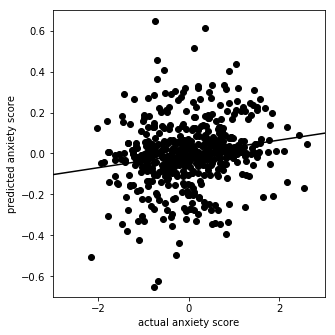

PLS regression:
r squared:
-0.0664214855113614
param selected:
[{'regression__n_components': 1}, {'regression__n_components': 2}, {'regression__n_components': 1}, {'regression__n_components': 1}, {'regression__n_components': 1}, {'regression__n_components': 2}]
correlation between actual and predicted anxiety:
(array([0.16300536]), array([0.00016155]))
CPM
 r squared for positive model:
-0.1150325419318674
 r squared for negative model:
-0.02335244283264548
corr between actual and predicted anxiety for positive model:
(array([0.02488892]), array([0.56714351]))
corr between actual and predicted anxiety for negative model:
(array([0.12551158]), array([0.00376911]))
Lasso regression:
 r squared:
-0.0037302144670718906
param selected:
[{'regression__alpha': 0.1}, {'regression__alpha': 1.0}, {'regression__alpha': 1.0}, {'regression__alpha': 1.0}, {'regression__alpha': 0.1}, {'regression__alpha': 1.0}]
correlation between actual and predicted anxiety:
(0.0054780500389520455, 0.89978213765494

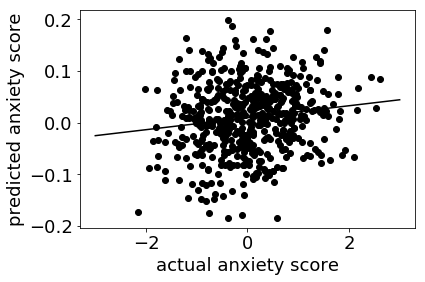

In [15]:
#try different models,plot results of best ones

steps = [
    ('standardize', StandardScaler()), 
    ('regression', Ridge())
]
pipeline = Pipeline(steps)
params = {
    'regression__alpha' : np.array([.01,.1,1,10,100,1000,10000,100000]),
}
#note: started with [.01,.1,1,10]. if 10 selected for every iteration of cv, added one higher power of 10 
#until the greatest parameter was not selected for every iteration of cv (vice versa if lowest selected every time).
# continued to do this below, within reason (i.e., sometimes it always chose the biggest value no matter how much
#I added higher choices, so I had to stop increassing it at some point)

r2,preds,param_selected =nested_cv(graph_data,anx_data,pipeline,params)
print('Ridge regression:')
print('r squared:')
print(r2)
print('param selected:')
print(param_selected)
print('correlation between actual and predicted anxiety:')
print(stats.pearsonr(preds,anx_data))
plt.figure(figsize=[5,5])

plt.plot(anx_data,preds,'o',color='black')
linreg = LinearRegression() #get regression line for plot

linreg.fit(anx_data.reshape(-1, 1),preds)
line = linreg.predict(np.array([-3,3]).reshape(-1,1))
plt.plot([-3,3],line,color='black')
plt.xlabel('actual anxiety score')
plt.ylabel('predicted anxiety score')
plt.xlim([-3,3])
plt.ylim([-.7,.7])
fontsize=18
plt.rc('font',**{ 'size':fontsize})
plt.tight_layout()
plt.show()

steps = [
    ('standardize', StandardScaler()), 
    ('regression', PLSRegression(scale=False))
]
pipeline = Pipeline(steps)
params = {
    'regression__n_components' : np.arange(1,11),
}
r2,preds,param_selected =nested_cv(graph_data,anx_data,pipeline,params)
print('PLS regression:')
print('r squared:')
print(r2)
print('param selected:')
print(param_selected)
print('correlation between actual and predicted anxiety:')
print(stats.pearsonr(preds,anx_data))


#cpm
r2_pos,r2_neg,preds_pos,preds_neg = cpm_cv(graph_data,anx_data)
print('CPM')
print(' r squared for positive model:')
print(r2_pos)
print(' r squared for negative model:')
print(r2_neg)

print('corr between actual and predicted anxiety for positive model:')
print(stats.pearsonr(preds_pos,anx_data))
print('corr between actual and predicted anxiety for negative model:')
print(stats.pearsonr(preds_neg,anx_data))



#lasso regression
steps = [
    ('standardize', StandardScaler()), 
    ('regression', Lasso())
]
pipeline = Pipeline(steps)
params = {
    'regression__alpha' : np.array([.01,.1,1,10,100,1000]),
}



r2,preds,param_selected =nested_cv(graph_data,anx_data.ravel(),pipeline,params)

print('Lasso regression:')
print(' r squared:')
print(r2)
print('param selected:')
print(param_selected)
print('correlation between actual and predicted anxiety:')
print(stats.pearsonr(preds.ravel(),anx_data.ravel()))

#pcr
steps = [
    ('standardize', StandardScaler()), 
    ('pca',PCA()),
    ('regression', LinearRegression())
]
pipeline = Pipeline(steps)
params = {
    'pca__n_components' : np.arange(1,50,5),
}
r2,preds,param_selected =nested_cv(graph_data,anx_data,pipeline,params)
print('PCR:')
print(' r squared:')
print(r2)
print('param selected:')
print(param_selected)
print('correlation between actual and predicted anxiety:')
print(stats.pearsonr(preds,anx_data))




#linear svm
steps = [
    ('standardize', StandardScaler()), 
    ('regression', SVR(kernel='linear'))
]
pipeline=Pipeline(steps)
params =   {'regression__C': np.array([.000001,.00001,.00001,.0001,.0001,.001,.01,.1,1,10])}

r2,preds,param_selected =nested_cv(graph_data,anx_data.ravel(),pipeline,params)
print('linear svm ')
print(' r squared:')
print(r2)
print('param selected:')
print(param_selected)
print('correlation between actual and predicted anxiety:')
print(stats.pearsonr(preds,anx_data.ravel()))

steps = [
    ('standardize', StandardScaler()), 
    ('regression', SVR(kernel='poly',degree=3))
]
pipeline=Pipeline(steps)
params =   {'regression__C': np.array([.0001,.001,.01,.1,1,10])}
r2,preds,param_selected =nested_cv(graph_data,anx_data.ravel(),pipeline,params)
print('nonlinear svm (degree 3)')
print(' r squared:')
print(r2)
print('param selected:')
print(param_selected)
print('correlation between actual and predicted anxiety:')
print(stats.pearsonr(preds,anx_data.ravel()))
#random forest 

#no need for pipeline/standardize because standardizing has no effect on random forest

params =    np.array([2,5,10,20,50])#max tree depth parameter
r2,preds,param_selected =rf_tune(graph_data,anx_data.ravel(),params)

print('random forest')
print('r squared:')
print(r2)
print('param selected:')
print(param_selected)
print('correlation between actual and predicted anxiety:')
print(stats.pearsonr(preds,anx_data.ravel()))

plt.plot(anx_data,preds,'o',color='black')
linreg = LinearRegression() #get regression line for plot

linreg.fit(anx_data.reshape(-1, 1),preds)
line = linreg.predict(np.array([-3,3]).reshape(-1,1))
plt.plot([-3,3],line,color='black')
plt.xlabel('actual anxiety score')
plt.ylabel('predicted anxiety score')
plt.show()


In [20]:
#try tangent matrix approach instead of pearson's correlation matrix (see Dadi et al, 2018, Varoquaox et al, 2010)

#need list of subjects (in order of outcome measure) to load timecourses into python

subsfile = input_data_folder + 'discovery/subsDisc.csv'
subs = pd.read_csv(subsfile, header=None)
subs = subs.values

#load timecourses
timecourses = []
for [sub] in subs:
    tc = np.loadtxt('../rest/' +sub+'/allreg_timecourse_files/fs_timecourses.csv',delimiter= ',')
    timecourses.append(tc)
    

In [21]:
#predict using ridge regression, freesurfer seg, tangent matrices
steps = [
    ('tangent', connectome.ConnectivityMeasure(kind="tangent",vectorize="True",discard_diagonal="True")),
    ('regression', Ridge())
    ]
pipeline = Pipeline(steps)
params = {
    'regression__alpha' : np.array([.01,.1,1,10,100,1000,10000,100000]),
}
r2,preds,param_selected =nested_cv(timecourses,anx_data,pipeline,params)
print('Ridge regression, tangent matrix:')
print(' r squared:')
print(r2)
print('param selected:')
print(param_selected)
print('correlation between actual and predicted anxiety:')
print(stats.pearsonr(preds,anx_data))



Ridge regression, tangent matrix:
 r squared:
0.0037617161751318795
param selected:
[{'regression__alpha': 1000.0}, {'regression__alpha': 1000.0}, {'regression__alpha': 100.0}, {'regression__alpha': 1000.0}, {'regression__alpha': 1000.0}, {'regression__alpha': 1000.0}]
correlation between actual and predicted anxiety:
(array([0.06438333]), array([0.13843226]))


### Schaefer segmentation

In [22]:
#load data
graph_data_file = input_data_folder + 'discovery/schaeferDisc.csv' 
graph_data = pd.read_csv(graph_data_file,header=None)
graph_data = np.transpose(graph_data.values)


In [23]:
#try models that worked best with freesufer (includes one linear and one nonlinear)
steps = [
    ('standardize', StandardScaler()), 
    ('regression', Ridge())
]
pipeline = Pipeline(steps)
params = {
    'regression__alpha' : np.array([.01,.1,1,10,100,1000,10000,100000,1000000,10000000]),
}
    #gave up on increasing regularization--kept wanting more


r2,preds,param_selected =nested_cv(graph_data,anx_data,pipeline,params)
print('Ridge regression:')
print(' r squared:')
print(r2)
print('param selected:')
print(param_selected)
print('correlation between actual and predicted anxiety:')
print(stats.pearsonr(preds,anx_data))

#random forest 

params =   np.array([2,5,10,20,50])
r2,preds,param_selected =rf_tune(graph_data,anx_data.ravel(),params,n_estimators=500)

print('random forest')
print(' r squared:')
print(r2)
print('param selected:')
print(param_selected)
print('correlation between actual and predicted anxiety:')
print(stats.pearsonr(preds,anx_data.ravel()))





Ridge regression:
 r squared:
0.0012543875440731433
param selected:
[{'regression__alpha': 10000000.0}, {'regression__alpha': 10000000.0}, {'regression__alpha': 10000000.0}, {'regression__alpha': 10000000.0}, {'regression__alpha': 10000000.0}, {'regression__alpha': 10000000.0}]
correlation between actual and predicted anxiety:
(array([0.06396105]), array([0.14104343]))
random forest
 r squared:
0.003190691110634414
param selected:
[2.0, 2.0, 2.0, 2.0, 10.0, 2.0]
correlation between actual and predicted anxiety:
(0.05713149303777914, 0.1886856320580397)


### Schaefer segmentation + freesurfer subcortical

In [24]:
#load data
graph_data_file = input_data_folder + 'discovery/schaeferFsDisc.csv' 
graph_data = pd.read_csv(graph_data_file,header=None)
graph_data = np.transpose(graph_data.values)

In [25]:
#try models that worked best with freesufer
steps = [
    ('standardize', StandardScaler()), 
    ('regression', Ridge())
]
pipeline = Pipeline(steps)


params = {
    'regression__alpha' : np.array([.01,.1,1,10,100,1000,10000,100000,1000000,10000000]),
}


r2,preds,param_selected =nested_cv(graph_data,anx_data,pipeline,params)
print('Ridge regression:')
print('r squared:')
print(r2)
print('param selected:')
print(param_selected)
print('correlation between actual and predicted anxiety:')
print(stats.pearsonr(preds,anx_data))


#random forest 


params =   np.array([2,5,10,20,50])#max depth parameter

r2,preds,param_selected =rf_tune(graph_data,anx_data.ravel(),params,n_estimators=500)

print('random forest')
print('r squared:')
print(r2)
print('param selected:')
print(param_selected)
print('correlation between actual and predicted anxiety:')
print(stats.pearsonr(preds,anx_data.ravel()))




Ridge regression:
r squared:
0.003439342253897637
param selected:
[{'regression__alpha': 1000000.0}, {'regression__alpha': 10000000.0}, {'regression__alpha': 10000000.0}, {'regression__alpha': 10000000.0}, {'regression__alpha': 1000000.0}, {'regression__alpha': 1000000.0}]
correlation between actual and predicted anxiety:
(array([0.05911789]), array([0.17374799]))
random forest
r squared:
0.0007393505299482239
param selected:
[2.0, 2.0, 5.0, 20.0, 20.0, 5.0]
correlation between actual and predicted anxiety:
(0.037821183110033275, 0.38441658038419)


### Shen segmentation

In [26]:
#load data
graph_data_file = input_data_folder + 'discovery/shenDisc.csv' 
graph_data = pd.read_csv(graph_data_file,header=None)
graph_data = np.transpose(graph_data.values)

In [27]:


#try models that worked best with freesufrf
steps = [
    ('standardize', StandardScaler()), 
    ('regression', Ridge())
]
pipeline = Pipeline(steps)


params = {
    'regression__alpha' : np.array([.01,.1,1,10,100,1000,10000,100000,1000000,10000000]),
}


r2,preds,param_selected =nested_cv(graph_data,anx_data,pipeline,params)
print('Ridge regression:')
print(' r squared:')
print(r2)
print('param selected:')
print(param_selected)
print('correlation between actual and predicted anxiety:')
print(stats.pearsonr(preds,anx_data))





#random forest 


params =   np.array([2,5,10,20,50])

r2,preds,param_selected =rf_tune(graph_data,anx_data.ravel(),params,n_estimators=500)

print('random forest')
print(' r squared:')
print(r2)
print('param selected:')
print(param_selected)
print('correlation between actual and predicted anxiety:')
print(stats.pearsonr(preds,anx_data.ravel()))






Ridge regression:
 r squared:
0.0013362662446514406
param selected:
[{'regression__alpha': 10000000.0}, {'regression__alpha': 1000000.0}, {'regression__alpha': 1000000.0}, {'regression__alpha': 10000000.0}, {'regression__alpha': 1000000.0}, {'regression__alpha': 1000000.0}]
correlation between actual and predicted anxiety:
(array([0.03801013]), array([0.38204422]))
random forest
 r squared:
0.0036480818932088654
param selected:
[2.0, 5.0, 2.0, 2.0, 5.0, 2.0]
correlation between actual and predicted anxiety:
(0.06489048947384161, 0.13534551072101206)


### Yeo 2011--17 networks version

In [15]:
#load data
graph_data_file = input_data_folder + 'discovery/yeo17Disc.csv' 
graph_data = pd.read_csv(graph_data_file,header=None)
graph_data = np.transpose(graph_data.values)

In [18]:

#try models that worked best with freesufer
steps = [
    ('standardize', StandardScaler()), 
    ('regression', Ridge())
]
pipeline = Pipeline(steps)


params = {
    'regression__alpha' : np.array([.01,.1,1,10,100,1000,10000,100000,1000000,10000000]),
}

r2,preds,param_selected =nested_cv(graph_data,anx_data,pipeline,params)
print('Ridge regression:')
print(' r squared:')
print(r2)
print('param selected:')
print(param_selected)
print('correlation between actual and predicted anxiety:')
print(stats.pearsonr(preds,anx_data))




#random forest 


params =   np.array([2,5,10,20,50])

r2,preds,param_selected =rf_tune(graph_data,anx_data.ravel(),params,n_estimators=500)

print('random forest')
print(' r squared:')
print(r2)
print('param selected:')
print(param_selected)
print('correlation between actual and predicted anxiety:')
print(stats.pearsonr(preds,anx_data.ravel()))





Ridge regression:
 r squared:
-3.281806191046677e-05
param selected:
[{'regression__alpha': 10000000.0}, {'regression__alpha': 10000000.0}, {'regression__alpha': 1000000.0}, {'regression__alpha': 10000000.0}, {'regression__alpha': 10000000.0}, {'regression__alpha': 10000000.0}]
correlation between actual and predicted anxiety:
(array([-0.0023576]), array([0.95677638]))
random forest
 r squared:
0.0018410282539712552
param selected:
[2.0, 2.0, 2.0, 2.0, 2.0, 2.0]
correlation between actual and predicted anxiety:
(0.04360311291095156, 0.3159212841361896)


### Yeo 2011--7 networks version plus freesurfer segmentation

In [31]:
#load data
graph_data_file = input_data_folder + 'discovery/yeo7FsDisc.csv' 
graph_data = pd.read_csv(graph_data_file,header=None)
graph_data = np.transpose(graph_data.values)

In [22]:
steps = [
    ('standardize', StandardScaler()), 
    ('regression', Ridge())
]
pipeline = Pipeline(steps)


params = {
    'regression__alpha' : np.array([.01,.1,1,10,100,1000,10000,100000,1000000]),
}


r2,preds,param_selected =nested_cv(graph_data,anx_data,pipeline,params)
print('Ridge regression:')
print(' r squared:')
print(r2)
print('param selected:')
print(param_selected)
print('correlation between actual and predicted anxiety:')
print(stats.pearsonr(preds,anx_data))








Ridge regression:
 r squared:
0.0005577275001615867
param selected:
[{'regression__alpha': 1000000.0}, {'regression__alpha': 1000000.0}, {'regression__alpha': 1000000.0}, {'regression__alpha': 1000000.0}, {'regression__alpha': 1000000.0}, {'regression__alpha': 1000000.0}]
correlation between actual and predicted anxiety:
(array([0.03953145]), array([0.36327137]))


### Power parcellation

In [33]:
#load data
graph_data_file = input_data_folder + 'discovery/powerDisc.csv' 
graph_data = pd.read_csv(graph_data_file,header=None)
graph_data = np.transpose(graph_data.values)
compos_anx_file = input_data_folder + 'discovery/composAnxPowerDisc.csv'
anx_data = pd.read_csv(compos_anx_file, header=None)
anx_data = anx_data.values

In [34]:


#try models that worked best with freesufrf
steps = [
    ('standardize', StandardScaler()), 
    ('regression', Ridge())
]
pipeline = Pipeline(steps)


params = {
    'regression__alpha' : np.array([.01,.1,1,10,100,1000,10000,10000,100000,1000000,10000000]),
}


r2,preds,param_selected =nested_cv(graph_data,anx_data,pipeline,params)
print('Ridge regression:')
print(' r squared:')
print(r2)
print('param selected:')
print(param_selected)
print('correlation between actual and predicted anxiety:')
print(stats.pearsonr(preds,anx_data))



#random forest 


params =   np.array([2,5,10,20,50])

r2,preds,param_selected =rf_tune(graph_data,anx_data.ravel(),params,n_estimators=500)

print('random forest')
print(' r squared:')
print(r2)
print('param selected:')
print(param_selected)
print('correlation between actual and predicted anxiety:')
print(stats.pearsonr(preds,anx_data.ravel()))





Ridge regression:
 r squared:
0.002310982436079412
param selected:
[{'regression__alpha': 10000000.0}, {'regression__alpha': 1000000.0}, {'regression__alpha': 1000000.0}, {'regression__alpha': 10000000.0}, {'regression__alpha': 10000000.0}, {'regression__alpha': 10000000.0}]
correlation between actual and predicted anxiety:
(array([0.07436444]), array([0.08720588]))
random forest
 r squared:
0.0032438192741797156
param selected:
[5.0, 10.0, 5.0, 20.0, 2.0, 10.0]
correlation between actual and predicted anxiety:
(0.05764360879534391, 0.18516311899732993)


# Stacking models (using freesurfer)

In [3]:
#reload graph data and anx data
graph_data_file = input_data_folder + 'discovery/fsDisc.csv' 
graph_data = pd.read_csv(graph_data_file,header=None)
graph_data = np.transpose(graph_data.values)

compos_anx_file = input_data_folder + 'discovery/composAnxDisc.csv'
anx_data = pd.read_csv(compos_anx_file, header=None)
anx_data = anx_data.values

### stacked model using freesurfer graph data AND freesurfer structural data

In [7]:

#get structural data
l_parc_data = pd.read_table(input_data_folder + 'discovery/aparc_stats_lh_Disc.txt')
l_parc_data = l_parc_data.drop(labels=['lh.aparc.thickness','lh_MeanThickness_thickness'],axis = 1)
print(l_parc_data.columns)
l_parc_data = l_parc_data.values
r_parc_data = pd.read_table(input_data_folder + 'discovery/aparc_stats_rh_Disc.txt')
r_parc_data = r_parc_data.drop(labels=['rh.aparc.thickness','rh_MeanThickness_thickness'],axis = 1)
r_parc_data = r_parc_data.values
aseg_data = pd.read_table(input_data_folder + 'discovery/aseg_stats_Disc.txt')
aseg_data = aseg_data.drop(['Measure:volume',  'BrainSegVol',
       'BrainSegVolNotVent', 'BrainSegVolNotVentSurf', 'lhCortexVol',
       'rhCortexVol', 'CortexVol', 'SubCortGrayVol', 'TotalGrayVol',
       'SupraTentorialVol', 'SupraTentorialVolNotVent',
       'SupraTentorialVolNotVentVox', 'MaskVol', 'BrainSegVol-to-eTIV',
       'MaskVol-to-eTIV', 'lhSurfaceHoles', 'rhSurfaceHoles', 'SurfaceHoles',],axis = 1)
print(aseg_data.columns)


aseg_data =aseg_data.values
#scale volumes by icv
aseg_data_corrected =aseg_data[:,:-1]/aseg_data[:,-1].reshape(aseg_data.shape[0],1)
#merge aseg and aparc data

aseg_aparc_data = np.concatenate((aseg_data_corrected,l_parc_data),axis = 1)
aseg_aparc_data = np.concatenate((aseg_aparc_data,r_parc_data),axis = 1)

Index(['lh_bankssts_thickness', 'lh_caudalanteriorcingulate_thickness',
       'lh_caudalmiddlefrontal_thickness', 'lh_cuneus_thickness',
       'lh_entorhinal_thickness', 'lh_fusiform_thickness',
       'lh_inferiorparietal_thickness', 'lh_inferiortemporal_thickness',
       'lh_isthmuscingulate_thickness', 'lh_lateraloccipital_thickness',
       'lh_lateralorbitofrontal_thickness', 'lh_lingual_thickness',
       'lh_medialorbitofrontal_thickness', 'lh_middletemporal_thickness',
       'lh_parahippocampal_thickness', 'lh_paracentral_thickness',
       'lh_parsopercularis_thickness', 'lh_parsorbitalis_thickness',
       'lh_parstriangularis_thickness', 'lh_pericalcarine_thickness',
       'lh_postcentral_thickness', 'lh_posteriorcingulate_thickness',
       'lh_precentral_thickness', 'lh_precuneus_thickness',
       'lh_rostralanteriorcingulate_thickness',
       'lh_rostralmiddlefrontal_thickness', 'lh_superiorfrontal_thickness',
       'lh_superiorparietal_thickness', 'lh_superiortem

In [38]:
#stacking model
#linear regression outer (stacking) model
linreg_pipeline_steps = [
 ('standardize', StandardScaler()), 
('regression', LinearRegression())
]
linreg_pipeline = Pipeline(linreg_pipeline_steps)

inner_pipeline_steps = [
 ('standardize', StandardScaler()), 
('regression', Ridge(1000))
]
inner_pipeline = Pipeline(inner_pipeline_steps)



r2,preds = stack([graph_data,aseg_aparc_data],anx_data,inner_pipeline,linreg_pipeline)
print(' r squared:')
print(r2)
print('correlation between actual and predicted anxiety:')
print(stats.pearsonr(preds,anx_data))





 r squared:
0.035987504110381874
correlation between actual and predicted anxiety:
(array([0.22200893]), array([2.36070104e-07]))


### inspired by Rahim et al 2016: stacking with multiple voxelwise fcmri maps
### for each of 85 fs seeds, make whole brain connectivity map. extract the zstat values from all grey matter voxels. make a ridge regression model from each seed map, with each voxel's value as predictor. stack these 85 models with another ridge model. tune lambda of this model with cv. 

### since this involves 85 really big data files and running >7000 models, I trained the base models on the HPC and saved the "meta features". the function I'm calling here reads in these results to build the stacked model.

### it does pretty poorly...perhaps having so many models in the stacked model is not good...

 r squared:
0.005360588361952745
correlation between actual and predicted anxiety:
(array([0.11200543]), array([0.00979339]))


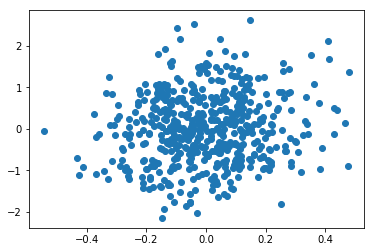

In [34]:
#load seed names
reg_table = pd.read_table('fs_regions.txt',header=None)
seeds = reg_table[1].values


outer_pipeline_steps = [
 ('standardize', StandardScaler()), 
('regression', Ridge())
]
outer_pipeline = Pipeline(outer_pipeline_steps)
param_grid = {'regression__alpha':[1,10,100,1000,10000,100000,1000000]}

r2,preds,_ = stack_from_meta_tune(anx_data,outer_pipeline,seeds,param_grid)
print(' r squared:')
print(r2)
print('correlation between actual and predicted anxiety:')
print(stats.pearsonr(preds,anx_data))



plt.plot(preds,anx_data,'o')

### stacked model with graph data, volume data, and amygdala seed map


In [6]:
##load voxelwise amyg conn
amyg_data = pd.read_csv(input_data_folder + 'discovery/seed_maps/Amygdala.csv',header=None).values
#zscore within subject but ignore zeros (which indicate missing data).
#dont want to include zeros or imputed values in zscoring w/in sub
zero_idx = amyg_data==0
amyg_naned = np.array(amyg_data)
amyg_naned[zero_idx] = np.nan
amyg_data_z = np.array(amyg_data)
for i in range(amyg_data.shape[0]):
    amyg_data_z[i,~np.isnan(amyg_naned[i,:])]= stats.zscore(amyg_data_z[i,~np.isnan(amyg_naned[i,:])])



 r squared:
0.05815717621046623
correlation between actual and predicted anxiety:
(array([0.25757009]), array([1.70967328e-09]))


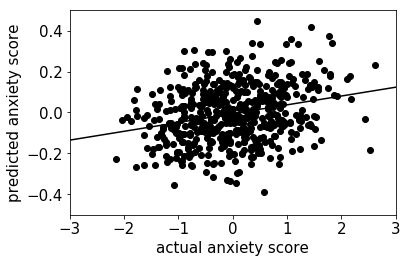

In [51]:
#linear regression outer (stacking) model
linreg_pipeline_steps = [
 ('standardize', StandardScaler()), 
('regression', LinearRegression())
]
linreg_pipeline = Pipeline(linreg_pipeline_steps)

inner_pipeline_steps = [
('impute',Imputer(missing_values=0,strategy='mean')),#only relevant for  amyg_data
('standardize', StandardScaler()), 
('regression', Ridge(1000))
]
inner_pipeline = Pipeline(inner_pipeline_steps)

r2,preds = stack([graph_data,aseg_aparc_data,amyg_data_z],anx_data,inner_pipeline,linreg_pipeline)
print(' r squared:')
print(r2)

print('correlation between actual and predicted anxiety:')
print(stats.pearsonr(preds,anx_data))



plt.plot(anx_data,preds,'o',color='black')
linreg = LinearRegression() #get regression line for plot

linreg.fit(anx_data.reshape(-1, 1),preds)
line = linreg.predict(np.array([-3,3]).reshape(-1,1))
plt.plot([-3,3],line,color='black')
plt.xlabel('actual anxiety score')
plt.ylabel('predicted anxiety score')
plt.xlim([-3,3])
plt.ylim([-.5,.5])
fontsize=18
plt.rc('font',**{ 'size':fontsize})
plt.tight_layout()
plt.savefig(output_data_folder + 'discovery/stack3.png')
#save data for making better figure.
np.savetxt(output_data_folder + 'discovery/preds_stack3_disc.csv',preds,delimiter=',')



0.0


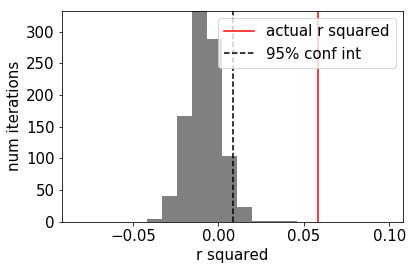

In [86]:
#permutation test
linreg_pipeline_steps = [
 ('standardize', StandardScaler()), 
('regression', LinearRegression())
]
linreg_pipeline = Pipeline(linreg_pipeline_steps)

inner_pipeline_steps = [
 ('standardize', StandardScaler()), 
('regression', Ridge(1000))
]
inner_pipeline = Pipeline(inner_pipeline_steps)



null_scores,p,actual_score = stack_perm([graph_data,aseg_aparc_data,amyg_data_z],
                                        anx_data,inner_pipeline,linreg_pipeline,1000,
                                        figname=output_data_folder + 'discovery/stack3_perm.png')
np.savetxt(output_data_folder + 'discovery/null_r2_disc.csv',null_r2,delimiter=',')

print(p)

### see if results hold in discovery sample when controlling for confounds

In [45]:
#regress out confounds, using ConfoundRegressor from skbold package. this regresses out confound using only 
#information from the training fold in cv, so you are not using test data in the model generation process.
#ConfoundRegressor takes the X matrix as a parameter, along with the confound matrix. 
#in a given fold of CV, it finds the relevant rows of X which are being used as training data and takes the 
#corresponding rows of confound matrix. for huge x matrices, comparing them elementwise is very time consuming, 
#so a shortcut is to compare sum across columns. this is a problem for my amyg data because i z scored across 
#columns, so they sum to zero. so I handle this by adding a column of random numbers to X, so sums will be unique.

conf_mat = pd.read_csv(input_data_folder + 'discovery/confMatDisc.csv',header=None)
conf_mat = conf_mat.values[:,1:]#first column is intercept which will be added by ConfoundRegressor

#add random column to amyg data so can use precise=False setting
#note: confirmed that this doesn't affect results in analysis when not controlling for confounds
np.random.seed(55)
randnum = np.random.rand(len(anx_data),1)
#make sure unique
print(len(np.unique(randnum)))
amyg_data_z_r = np.concatenate((amyg_data_z,randnum),axis=1)



steps = [
    ('standardize', StandardScaler()), 
    ('regression', LinearRegression())
]
linreg_pipeline = Pipeline(steps)

#add ConfoundRegressor step to inner model 

inner_pipeline_steps = [
    #note--has to be in this order, if X data is transformed ConfoundRegressor wont work
    ('conf_reg',ConfoundRegressor(conf_mat,graph_data)),#X data will be reset within stack function
    ('impute',Imputer(missing_values=0,strategy='mean')),
 ('standardize', StandardScaler()), 
('regression', Ridge(1000))
]
inner_pipeline = Pipeline(inner_pipeline_steps)


r2,preds = stack([graph_data,aseg_aparc_data,amyg_data_z_r],anx_data,
                                          inner_pipeline,linreg_pipeline)
print('stacked model plus confound regression:')

print(' r squared:')
print(r2)
print('correlation between actual and predicted anxiety:')
print(stats.pearsonr(preds,anx_data))



531
stacked model plus confound regression:
 r squared:
0.046139766722673836
correlation between actual and predicted anxiety:
(array([0.23584534]), array([3.80550394e-08]))


0.0


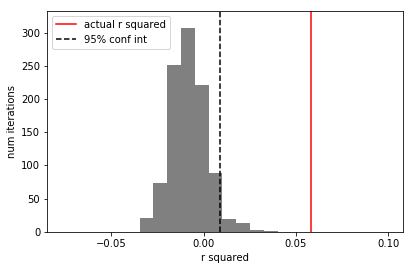

In [22]:
#permutation for confound version

linreg_pipeline_steps = [
 ('standardize', StandardScaler()), 
('regression', LinearRegression())
]
linreg_pipeline = Pipeline(linreg_pipeline_steps)

inner_pipeline_steps = [
    #note--has to be in this order, if X data is transformed ConfoundRegressor wont work
    ('conf_reg',ConfoundRegressor(conf_mat,graph_data)),#X data will be reset within stack function
    ('impute',Imputer(missing_values=0,strategy='mean')),
 ('standardize', StandardScaler()), 
('regression', Ridge(1000))
]



null_scores,p,actual_score = stack_perm([graph_data,aseg_aparc_data,amyg_data_z_r],
                                        anx_data,inner_pipeline,linreg_pipeline,1000,
                                        figname=output_data_folder + 'discovery/stack3_conf_disc_perm.png')

print(p)

# predict on held out test data

In [8]:
#load test data
graph_data_file_test = input_data_folder + 'holdout/fsHoldout.csv'
graph_data_test = pd.read_csv(graph_data_file_test,header=None)
graph_data_test = np.transpose(graph_data_test.values)

compos_anx_file_test =  input_data_folder + 'holdout/composAnxTest.csv'
anx_data_test = pd.read_csv(compos_anx_file_test, header=None)
anx_data_test = anx_data_test.values

print(graph_data_test.shape)
print(anx_data_test.shape)

#get structural data
l_parc_data = pd.read_table( input_data_folder + 'holdout/aparc_stats_lh_Holdout.txt')
l_parc_data = l_parc_data.drop(labels=['lh.aparc.thickness','lh_MeanThickness_thickness'],axis = 1)
l_parc_data = l_parc_data.values


r_parc_data = pd.read_table( input_data_folder + 'holdout/aparc_stats_rh_Holdout.txt')
r_parc_data = r_parc_data.drop(labels=['rh.aparc.thickness','rh_MeanThickness_thickness'],axis = 1)
r_parc_data = r_parc_data.values


aseg_data = pd.read_table( input_data_folder + 'holdout/aseg_stats_Holdout.txt')
aseg_data = aseg_data.drop(['Measure:volume',  'BrainSegVol',
       'BrainSegVolNotVent', 'BrainSegVolNotVentSurf', 'lhCortexVol',
       'rhCortexVol', 'CortexVol', 'SubCortGrayVol', 'TotalGrayVol',
       'SupraTentorialVol', 'SupraTentorialVolNotVent',
       'SupraTentorialVolNotVentVox', 'MaskVol', 'BrainSegVol-to-eTIV',
       'MaskVol-to-eTIV', 'lhSurfaceHoles', 'rhSurfaceHoles', 'SurfaceHoles',],axis = 1)

aseg_data =aseg_data.values
#scale volumes by icv
aseg_data_corrected =aseg_data[:,:-1]/aseg_data[:,-1].reshape(aseg_data.shape[0],1)


#merge aseg and aparc data

aseg_aparc_data_test = np.concatenate((aseg_data_corrected,l_parc_data),axis = 1)
aseg_aparc_data_test = np.concatenate((aseg_aparc_data_test,r_parc_data),axis = 1)
print(aseg_aparc_data_test.shape)




#amyg data
amyg_data_test = pd.read_csv(input_data_folder + 'holdout/Amygdala.csv',header=None).values
#zscore within subject but ignore zeros (which indicate missing data). dont want to include zeros or imputed values in zscoring w/in sub
zero_idx_test = amyg_data_test==0
amyg_naned_test = np.array(amyg_data_test)
amyg_naned_test[zero_idx_test] = np.nan
amyg_data_z_test = np.array(amyg_data_test)
for i in range(amyg_data_test.shape[0]):
    amyg_data_z_test[i,~np.isnan(amyg_naned_test[i,:])]= stats.zscore(
        amyg_data_z_test[i,~np.isnan(amyg_naned_test[i,:])])



(348, 3570)
(348, 1)
(348, 85)


 r squared:
-0.04004173526936006
correlation between actual and predicted anxiety:
(array([0.01654413]), array([0.7584344]))


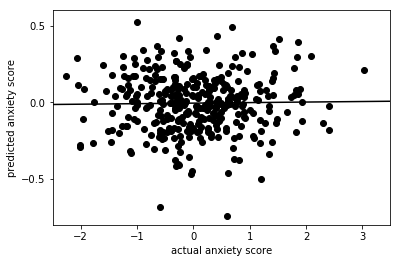

In [9]:
#rebuild best model using all the training data (no cv) and test on holdout

Xs_train = [graph_data,aseg_aparc_data,amyg_data_z]
Xs_test = [graph_data_test,aseg_aparc_data_test,amyg_data_z_test]
y_train = anx_data
y_test = anx_data_test


linreg_pipeline_steps = [
 ('standardize', StandardScaler()), 
('regression', LinearRegression())
]
linreg_pipeline = Pipeline(linreg_pipeline_steps)

inner_pipeline_steps = [
('impute',Imputer(missing_values=0,strategy='mean')),#only relevant for  amyg_data
('standardize', StandardScaler()), 
('regression', Ridge(1000))
]
inner_pipeline = Pipeline(inner_pipeline_steps)

r2,preds,weights = stack_test(Xs_train,y_train,Xs_test,y_test,inner_pipeline,linreg_pipeline)

print(' r squared:')
print(r2)

print('correlation between actual and predicted anxiety:')
print(stats.pearsonr(y_test,preds))



plt.plot(y_test,preds,'o',color='black')
linreg = LinearRegression() #get regression line for plot

linreg.fit(y_test.reshape(-1, 1),preds)
line = linreg.predict(np.array([-3,3.5]).reshape(-1,1))
plt.plot([-3,3.5],line,color='black')
plt.xlabel('actual anxiety score')
plt.ylabel('predicted anxiety score')
plt.xlim([-2.5,3.5])
plt.ylim([-.8,.6])
fontsize=18
plt.rc('font',**{ 'size':fontsize})
plt.tight_layout()
plt.show
plt.savefig(output_data_folder + 'holdout/stack_holdout.png')
np.savetxt(output_data_folder + 'holdout/preds_stack3_holdout.csv',preds,delimiter=',')



0.962

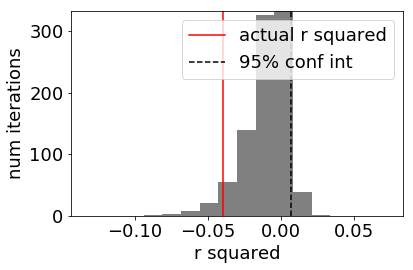

In [50]:
# permutation test
null_r2,p,act = stack_test_perm(Xs_train,y_train,Xs_test,y_test,
                inner_pipeline,linreg_pipeline,1000,output_data_folder + 'holdout/stack_holdout_perm.png')
np.savetxt(output_data_folder + 'holdout/null_r2_holdout.csv',null_r2,delimiter=',')
p

#### trying to understand results more--did we shoot ourselves in the foot by testing too many models? to test this explanation of model failure, see if a tested early in model comparison process --ridge regression with freesurfer segmentation on graph data only--does better in holdout than final model (above). it doesn't.


In [10]:
steps = [
    ('standardize', StandardScaler()), 
    ('regression', Ridge())
]
pipeline = Pipeline(steps)
params = {
    'regression__alpha' : np.array([.01,.1,1,10,100,1000,10000,100000]),
}


cv = cv_stratified(6,y_train)
grid= GridSearchCV(estimator=pipeline, param_grid=params, cv=cv, scoring='r2')  

grid.fit(graph_data, y_train)
preds = grid.best_estimator_.predict(graph_data_test)
r2 = r2_score(y_test,preds)
print(r2)
print(stats.pearsonr(y_test,preds))

-0.06054602934134379
(array([0.00269189]), array([0.9600937]))


In [11]:
#bootstrap test to formally compare the two models
test_inds = np.arange(len(y_test))
n_iter = 1000
m1_r2 = np.zeros(n_iter)
m2_r2 = np.zeros(n_iter)
for i in range(n_iter):
    
    #sample the test data
    ind_sampled = np.random.choice(test_inds,len(test_inds))
    y_test_samp = y_test[ind_sampled]
    graph_data_test_samp = graph_data_test[ind_sampled]
    Xs_test_samp = [graph_data_test[ind_sampled],aseg_aparc_data_test[ind_sampled],amyg_data_z_test[ind_sampled]]

    #compute r2 of the two models on the resampled test data
    m1_r2[i],_,_ = stack_test(Xs_train,y_train,Xs_test_samp,y_test_samp,inner_pipeline,linreg_pipeline)

    preds = grid.best_estimator_.predict(graph_data_test_samp)
    m2_r2[i] = r2_score(y_test_samp,preds)

#calculate confidence intervals
ci_m1 = [np.percentile(m1_r2, 2.5),np.percentile(m1_r2, 97.5)]
ci_m2 = [np.percentile(m2_r2, 2.5),np.percentile(m2_r2, 97.5)]
print(ci_m1)
print(ci_m2)
    



[-0.0876838370402782, 0.004772020818959784]
[-0.11688422232308911, -0.004602838813814639]


[-0.01074409361717874, 0.0477092886991899]


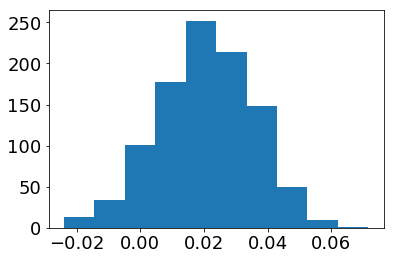

In [12]:
dif_r2 = m1_r2-m2_r2
plt.hist(dif_r2)
ci_dif = [np.percentile(dif_r2, 2.5),np.percentile(dif_r2, 97.5)]
print(ci_dif)